In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sn
import matplotlib.pyplot as plt

## Read train set and test set

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
addition_data = pd.read_csv('train__dataset.csv')

In [3]:
df_train = pd.concat([df_train, addition_data],axis=0, ignore_index=True)

# Feature Engineering

In [4]:
from datetime import datetime as dt
def fe(df):
    
        df = df.drop(columns = ['id'])
        
        # Fix date anomalies (pd.to_datetime throws parsing error for some days, see anomalies section).
        df['arrival_year_month'] = pd.to_datetime(df['arrival_year'].astype(str) + df['arrival_month'].astype(str), format='%Y%m')
        df.loc[df.arrival_date > df.arrival_year_month.dt.days_in_month, 'arrival_date'] = df.loc[df.arrival_date > df.arrival_year_month.dt.days_in_month, 'arrival_year_month'].dt.days_in_month
        df.drop(columns='arrival_year_month', inplace=True)
        
        #extract dayoftheweek from those dates.
        
        df['dateofarrival'] = pd.to_datetime(df['arrival_year'].astype(str) + df['arrival_month'].astype(str) + df['arrival_date'].astype(str), format='%Y%m%d')
        #df['dayoftheweek'] = df['dateofarrival'].dt.weekday
        
        df.drop(columns=['dateofarrival'], inplace=True)
        
        return df

In [5]:
df_train_fe = fe(df_train)
df_test_fe = fe(df_test)

##  Analyse the data sets to extract insights

In [6]:
profile = ProfileReport(df_train, title="Pandas Profiling Report", vars={"num": {"low_categorical_threshold": 0}})

In [7]:
#profile.to_notebook_iframe()

In [8]:
profile2 = ProfileReport(df_test, title="Pandas Profiling Report")

## Plot Correlation Matrix

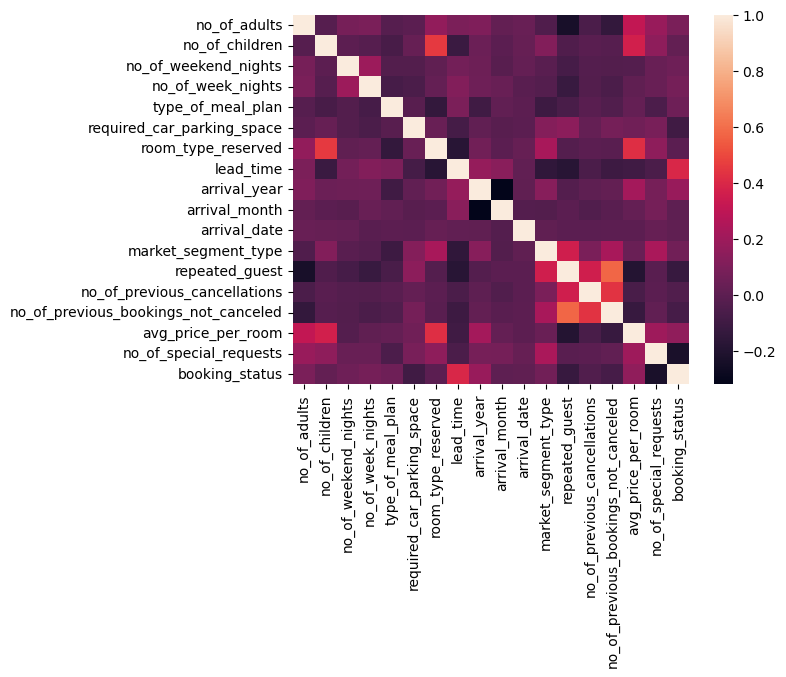

In [9]:
corr_matrix = df_train_fe.corr()
sn.heatmap(corr_matrix, annot=False)
plt.show()

Lead time appears to be the most important feature in predicting if the booking carried on or not, also the price per room. This means people who made the reservation with more time in advance are more likely to cancel the reservation, and that avg price has an effect on cancelation.

## Train/Validation split of training data for model evaluation

In [10]:
y = df_train_fe['booking_status']
X = df_train_fe.drop(columns= ['booking_status'], axis=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[X.columns] = scaler.fit_transform(X[X.columns])
df_test_fe[df_test_fe.columns] = scaler.fit_transform(df_test_fe[df_test_fe.columns])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.33, random_state=2)

# Feature Selection

In [12]:
%%time
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
clf = XGBClassifier(n_estimators=2000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
selector = SelectFromModel(clf,threshold=0.02, max_features=17)
selector.fit(X,y)

CPU times: user 3min 18s, sys: 1.12 s, total: 3min 19s
Wall time: 53.6 s


SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.67,
                                        early_stopping_rounds=None,
                                        enable_categorical=False, eta=0.2,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=4,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        n_estimators=2000, n_jobs=-1,
                                        num_parallel_tree=None, predictor=None, ...),
                max_features=17, threshold=0.02)

In [13]:
selected_features = X.columns[selector.get_support()]
not_selected_features = set(X.columns) - set(selected_features)

sel_imp = pd.DataFrame({'features':X.columns, 'importances': selector.estimator_.feature_importances_}).sort_values('importances', ascending=False).reset_index(drop=True)
sel_imp['selected'] = [x in selected_features for x in sel_imp['features']]
print(' Number of features selected = ', len(selected_features), '\n Selected features: ')
sel_imp

 Number of features selected =  10 
 Selected features: 


,features,importances,selected
0,market_segment_type,0.202973,True
1,repeated_guest,0.150085,True
2,no_of_special_requests,0.146059,True
3,required_car_parking_space,0.140852,True
4,arrival_year,0.088587,True
5,lead_time,0.068492,True
6,avg_price_per_room,0.032497,True
7,arrival_month,0.032150,True
8,no_of_adults,0.024540,True
9,type_of_meal_plan,0.023543,True


In [14]:
X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
df_test_fe_sel=df_test_fe[selected_features]
df_test_fe_sel.shape

(28068, 10)

# Model training and predicting

XGBC

In [15]:
%%time
xgbc = XGBClassifier(n_estimators=2000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67)
xgbc.fit(X_train_sel,y_train)
y_xgbc = xgbc.predict_proba(X_val_sel)

CPU times: user 1min 35s, sys: 838 ms, total: 1min 35s
Wall time: 25 s


Gradient Boosting Classifier

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train_sel,y_train)
y_gbc = gbc.predict_proba(X_val_sel)

Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_sel, y_train)
y_rfc = rfc.predict_proba(X_val_sel)

In [18]:
%%time
from sklearn.ensemble import VotingClassifier
estimators=[('xgbc', xgbc), ('gbc',gbc),('rfc',rfc)] 
vc = VotingClassifier(estimators, voting='soft')
vc.fit(X_train_sel, y_train)
y_vc = vc.predict_proba(X_val_sel)

CPU times: user 1min 55s, sys: 900 ms, total: 1min 56s
Wall time: 45.6 s


# Model Evaluation

In [19]:
from sklearn.metrics import roc_auc_score
#XGBC
aucxgbc = roc_auc_score(y_val, y_xgbc[:,1])
print('AUC of XGBC= ', aucxgbc)
#GBC
aucgbc = roc_auc_score(y_val, y_gbc[:,1])
print('AUC of GBC= ', aucgbc)
#RFC
aucrfc = roc_auc_score(y_val, y_rfc[:,1])
print('AUC  of RFC = ', aucrfc)
#VC
aucvc = roc_auc_score(y_val, y_vc[:,1])
print('AUC  of VC = ', aucvc)

AUC of XGBC=  0.9106018690173712
AUC of GBC=  0.8865256717635692
AUC  of RFC =  0.889409401361832
AUC  of VC =  0.910392717517127


In [20]:
out_model = xgbc
y_out = out_model.predict_proba(df_test_fe_sel)
out_df = pd.read_csv('sample_submission.csv')
out_df['booking_status'] = y_out[:,1]
out_df.to_csv('Submissions/TV_Branch/SubmissionPSS3E7TV_v2.csv', index=False)